# A study on Normality tests on Interferometer data containing glitches  
Here, I will be studying different statistical tests for normality to see how they function and whether they would be a good fit for whitened GW time-series signals containing glitches.

The hypotheses here are as follows

H0: The given signal is non-gaussian
H1: The given signal is non non-gaussian (Not necessarily a gaussian but could be any other type of distribution)

A lot of these tests treat data as points in a distribution as independent points that are not associated with one another, i.e. there is no consideration of the temporal component that time series data is inherently based on. So a lot of these tests may not be the best way to be assessing our data but it would still be helpful to go through them all the same.

Some of the tests I will be looking at are:

- The Shapiro-Wilk test
- The Kolmogorov-Smirnov test
- The Anderson-Darling test
- The Cramer-von Mises Criterion
- Kullback-Liebler divergence

I am also interested in exploring cumulant analysis, but that has a lower priority.

The solution I am looking for here is that some the test I come up with should have the least amount of false positives while also suiting the data we are working with.

# The gaussian distribution

Below is how a normal distribution would look

![Normal Distribution](images/normal_distribution.png)

With the following formula

$$
f(x) = \frac{1}{\sqrt{2\pi \sigma^2}}e^{-\frac{(x - \mu)^2}{2\sigma^2}}
$$

where $\mu$ is the distribution mean and $\sigma^2$ is the variance.

The example of a gaussian we have in our case is the white noise we will be injecting our glitch into to study its properties.

I will now be loading up the packages we need for this project along with the glitch archetype that we plan on studying. 

In [1]:
import pycbc
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
from scipy import stats
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries
from matplotlib.ticker import ScalarFormatter

# plt.style.use('Solarize_Light2')


/home/ashishmathew0297/miniconda3/envs/gengli_env/lib/python3.12/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


# Loading the data
Now, I have been provided a dataset with glitch information from the O3 runs of all the interferometers. Here I will be focusing on Tomte glitches from the LIGO interferometer to study how these statistical tests would help give us an idea whether we are able to differentiate between a glitch and its surrounding white/gaussian glitch.

In [2]:
glitches = pd.read_csv('./data/O3a_allifo.csv')

Here's a breakdown of the CSV data

- **GPStime**: The timestamp in GPS format indicating the event time.
- **peakFreq**: The frequency at which the signal has the highest intensity.
- **snr**: Signal-to-glitch ratio, indicating the clarity of the signal.
- **amplitude**: The strength or height of the signal wave.
- **centralFreq**: The central frequency of the signal's spectral content.
- **duration**: The time span of the signal event.
- **bandwidth**: The range of frequencies covered by the signal.
- **chisq**: The chi-squared statistic for assessing signal fit quality.
- **chisqDof**: The degrees of freedom used in the chi-squared test.
- **confidence**: The likelihood or certainty of the detection.
- **id**: A unique identifier for the signal event.
- **ifo**: The interferometer associated with the signal detection.
- **label**: Classification or annotation of the event.
- **imgUrl**: Link to an image or visual representation of the signal.
- **Q-value**: Quality factor indicating the sharpness of the signal.

In [3]:
tomte_glitches = glitches[(glitches['label'] == 'Tomte') & (glitches['ifo'] == 'L1')]
tomte_glitches.shape

(20804, 15)

# Exploring Tomte Glitches

The code below will give us a visualization on how long each of the tomte glitches are.

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_33171/2946673380.py:3: SyntaxWarning: invalid escape sequence '\m'
  label=f'$\mu=$'+str(np.round(np.mean(tomte_glitches['duration'].values), 3))+' s')


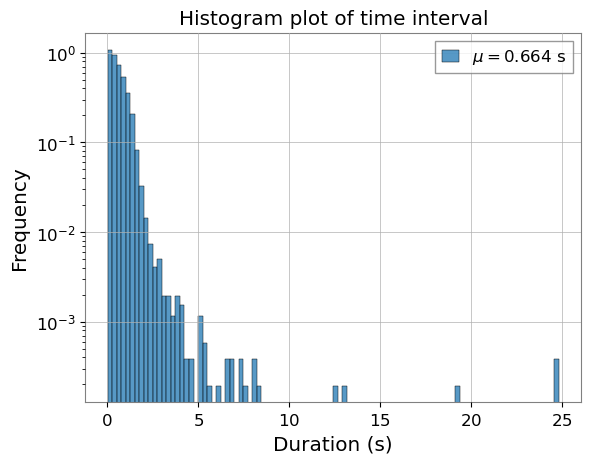

In [4]:
np.round(np.mean(tomte_glitches['duration'].values), 2)
sns.histplot(data=tomte_glitches['duration'].values, bins=100, stat='density',
         label=f'$\mu=$'+str(np.round(np.mean(tomte_glitches['duration'].values), 3))+' s')
plt.yscale('log')
plt.xlabel('Duration (s)')
plt.ylabel('Frequency')
plt.title('Histogram plot of time interval')
plt.legend()

I will now be loading up the dataset from `gwpy` using the TimeSeries package.

In [5]:
def get_noise_data(selected, srate=4096, tw=3, ifo='L1', begin=0, end=50):
    data_readings = []
    g_stars = selected['GPStime'].iloc[begin:end]

    # fetching the timeseries data according to GPStime
    for g_star in g_stars:
        # Fetching the data with the time window around the glitch
        glitch = TimeSeries.fetch_open_data(ifo, g_star - tw ,  g_star + tw, sample_rate=srate)
        # noise = noise.to_pycbc()

        # Whitening the noise signal
        whitened_noise, psd = glitch.to_pycbc().whiten(len(glitch) / (2 * srate),
                                        len(glitch)/( 4 * srate),
                                        remove_corrupted = False,
                                        return_psd = True)
        
        # Crop 1s at each side to avoid border effects.
        # Doing the same to the pure glitch for plotting purposes 
        whitened_noise = whitened_noise[int(srate * 1):-int(srate * 1)]
        glitch = glitch[int(srate * 1):-int(srate * 1)]

        # We then convert this data from pycbc to a TimeSeries object
        # and fetch the q-scan of it
        data = TimeSeries(whitened_noise, sample_rate = srate)
        q_scan = data.q_transform(qrange=[4,64], frange=[10, 2048],
                                tres=0.002, fres=0.5, whiten=False)

        # t = data.times[int(srate * 1.5):-int(srate * 1.5)]
        # y = data.value[int(srate * 1.5):-int(srate * 1.5)]
        # noise_readings.append(whitened_noise)
        data_readings.append((g_star, glitch, data, q_scan))

    data_df = pd.DataFrame(data_readings, columns=['GPStime', 'glitch', 'data', 'q_transform'])
    return data_df

In previous testing, I had come across an anomalous glitch that failed the Shapiro Wilks test between rows 100 to 150 of the dataset. So I will, for the most part, be refering to this data

In [6]:
# The default tw here is 3 which will, in the end,
# gives us 2 seconds of time around the glitch
tw = 3
data_df = get_noise_data(tomte_glitches, tw=tw, begin=100, end=150)

/home/ashishmathew0297/miniconda3/envs/gengli_env/lib/python3.12/site-packages/gwpy/signal/qtransform.py:124: UserWarning: upper frequency of 2048.00 is too high for the given Q range, resetting to 1291.05
  warnings.warn('upper frequency of %.2f is too high for the given '
/home/ashishmathew0297/miniconda3/envs/gengli_env/lib/python3.12/site-packages/gwpy/signal/qtransform.py:124: UserWarning: upper frequency of 2048.00 is too high for the given Q range, resetting to 1291.05
  warnings.warn('upper frequency of %.2f is too high for the given '


# Studying our data

Let's look at some of the data we have loaded up to see how it looks. We will be looking at it both as a weveform from the IFO and also as a normal distribution since the latter is what our tests in the upcoming sections care more about.

Given below are the first 25 signals plotted as waveforms. 

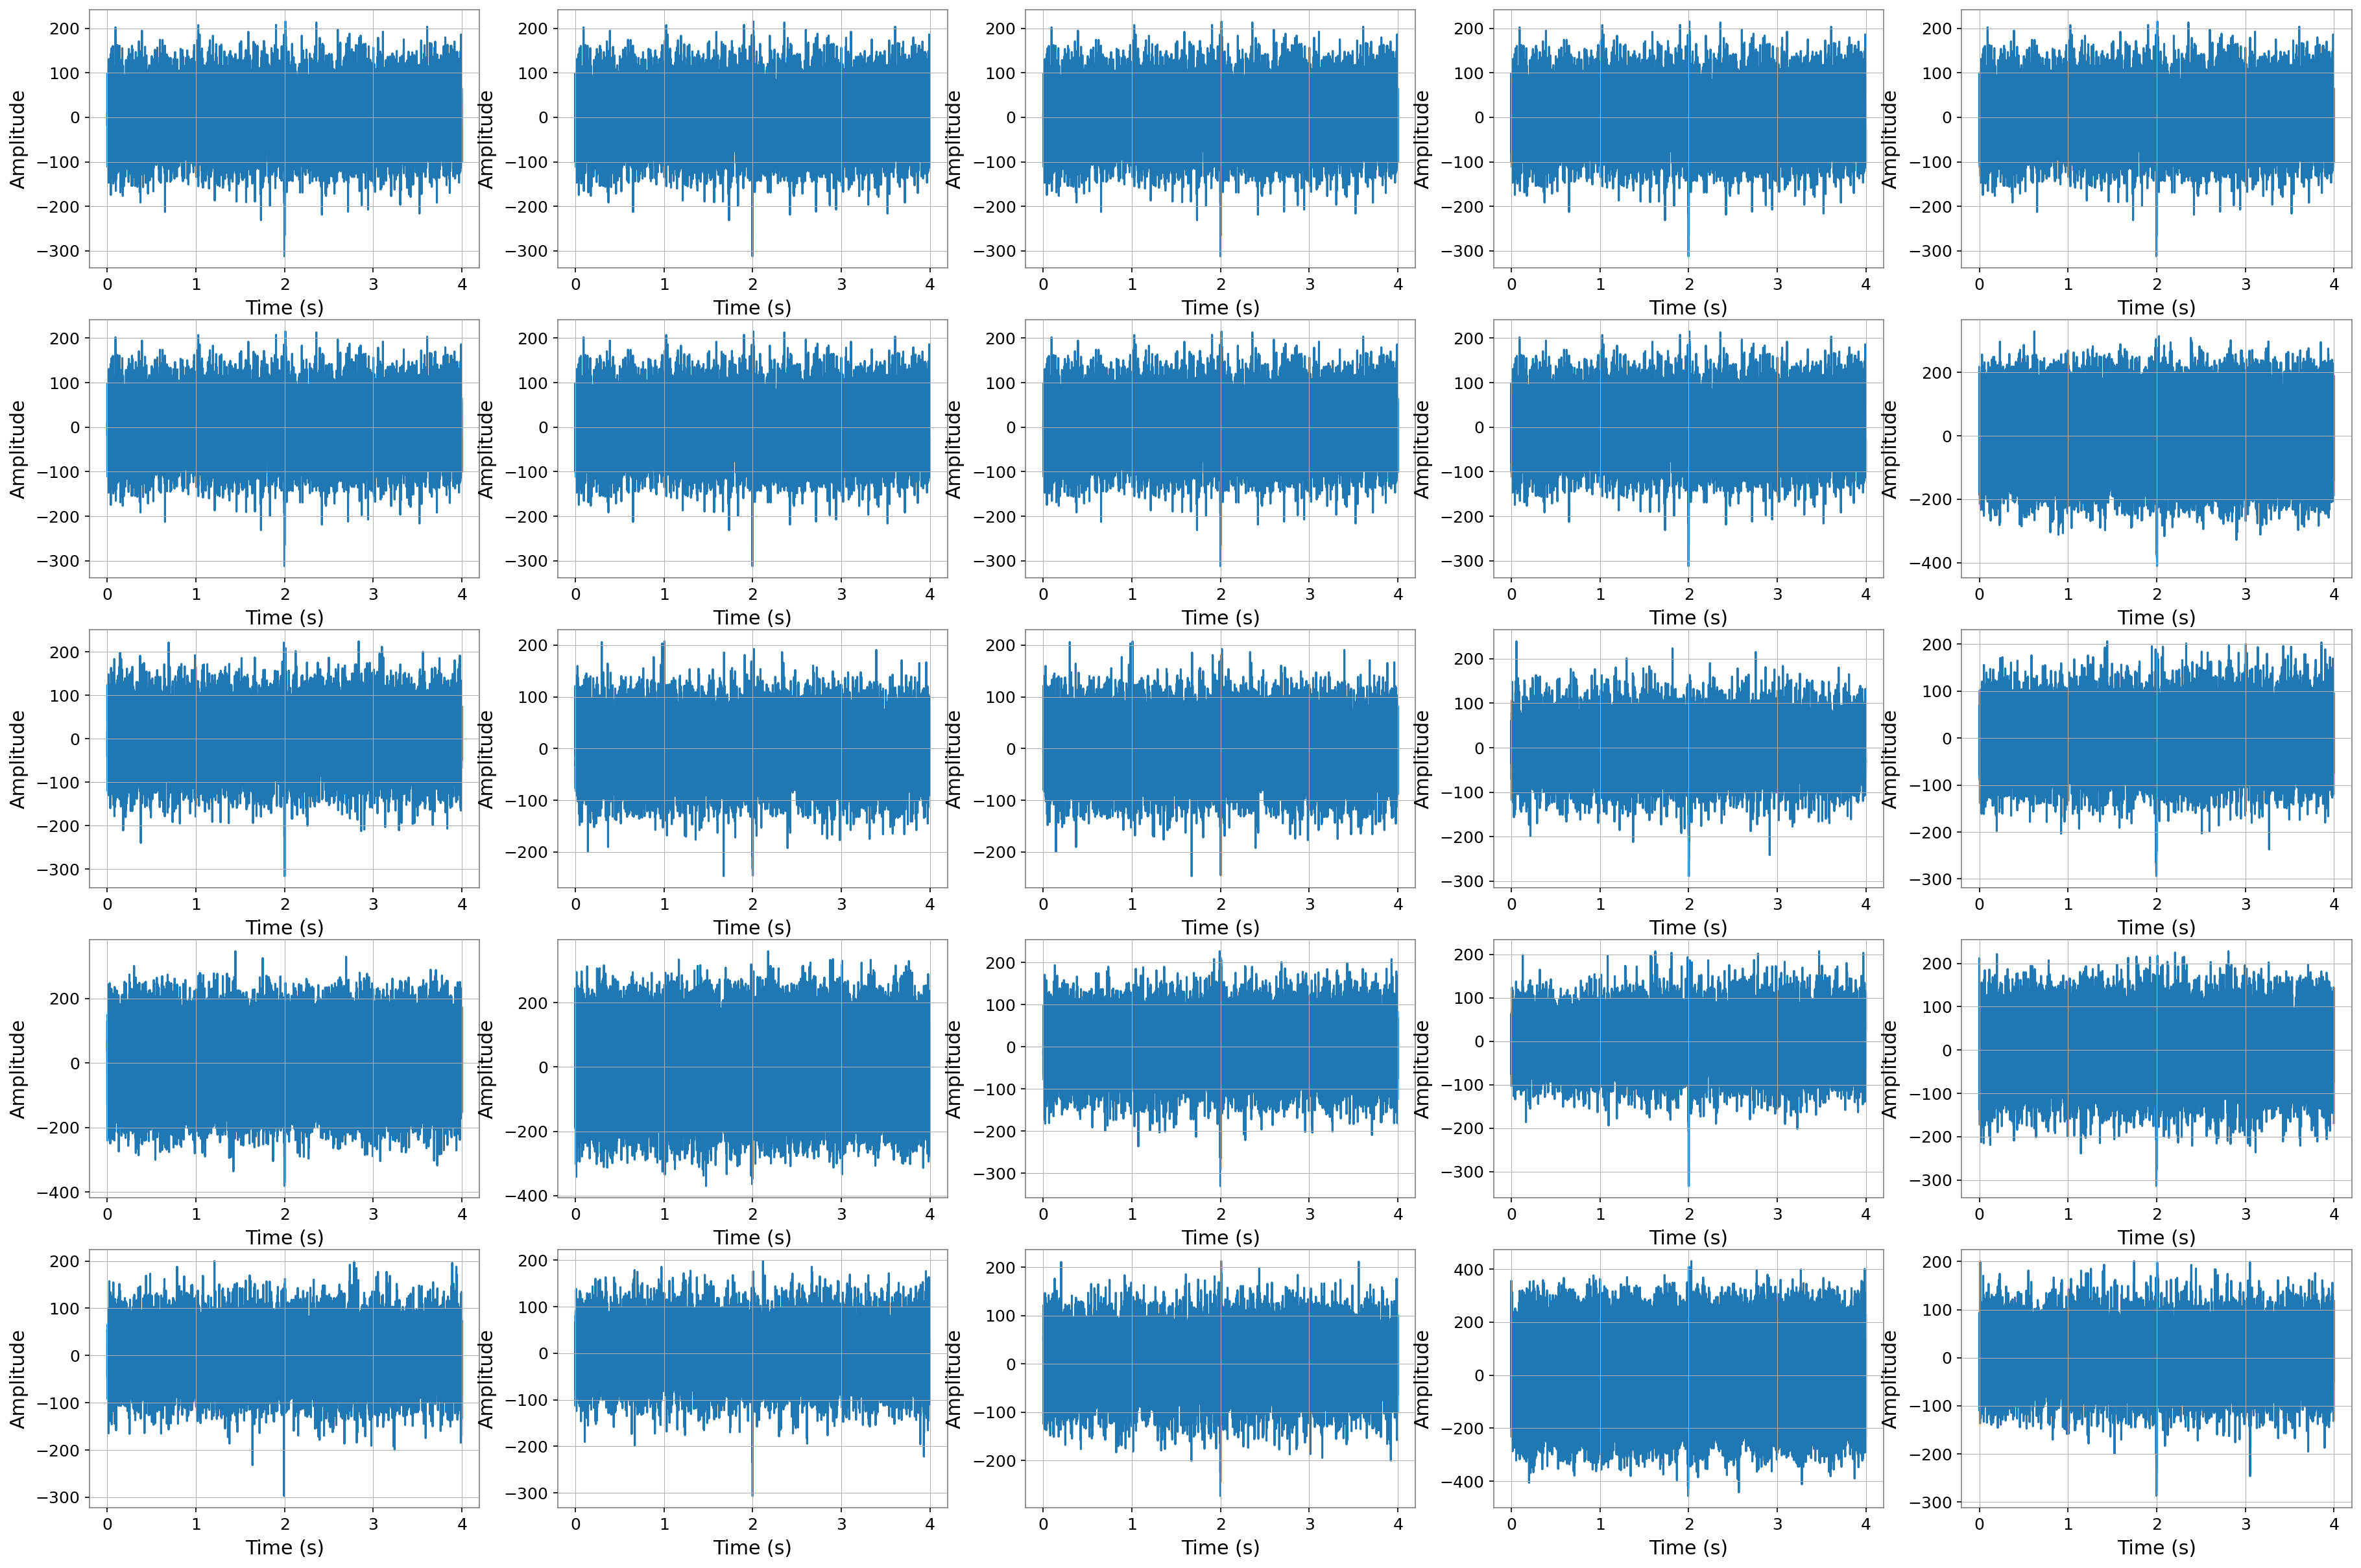

In [7]:
fig, axes = plt.subplots(5,5, figsize=(30,20), dpi=150)

# Looping through the axes
for idx, ax in enumerate(list(itertools.chain.from_iterable(axes))):
    # sns.kdeplot(ax=ax, data=data_df['data'].iloc[idx].value)
    sns.lineplot(ax=ax, x=data_df['data'].iloc[idx].times, y=data_df['data'].iloc[idx].value)
    # sns.lineplot(ax=ax, x=np.array(data_df['glitch'].iloc[0].times) - data_df['GPStime'].iloc[0] + (tw-1), y=data_df['glitch'].iloc[idx].value)
    ax.set_ylabel('Amplitude')
    ax.set_xlabel('Time (s)')

plt.show()

Plotted below is the same data but in the form of a probability distribution. A lot of the tests we use will be treating this data as the latter. It would be interesting to see how they work and if they would be relevant to our use case.

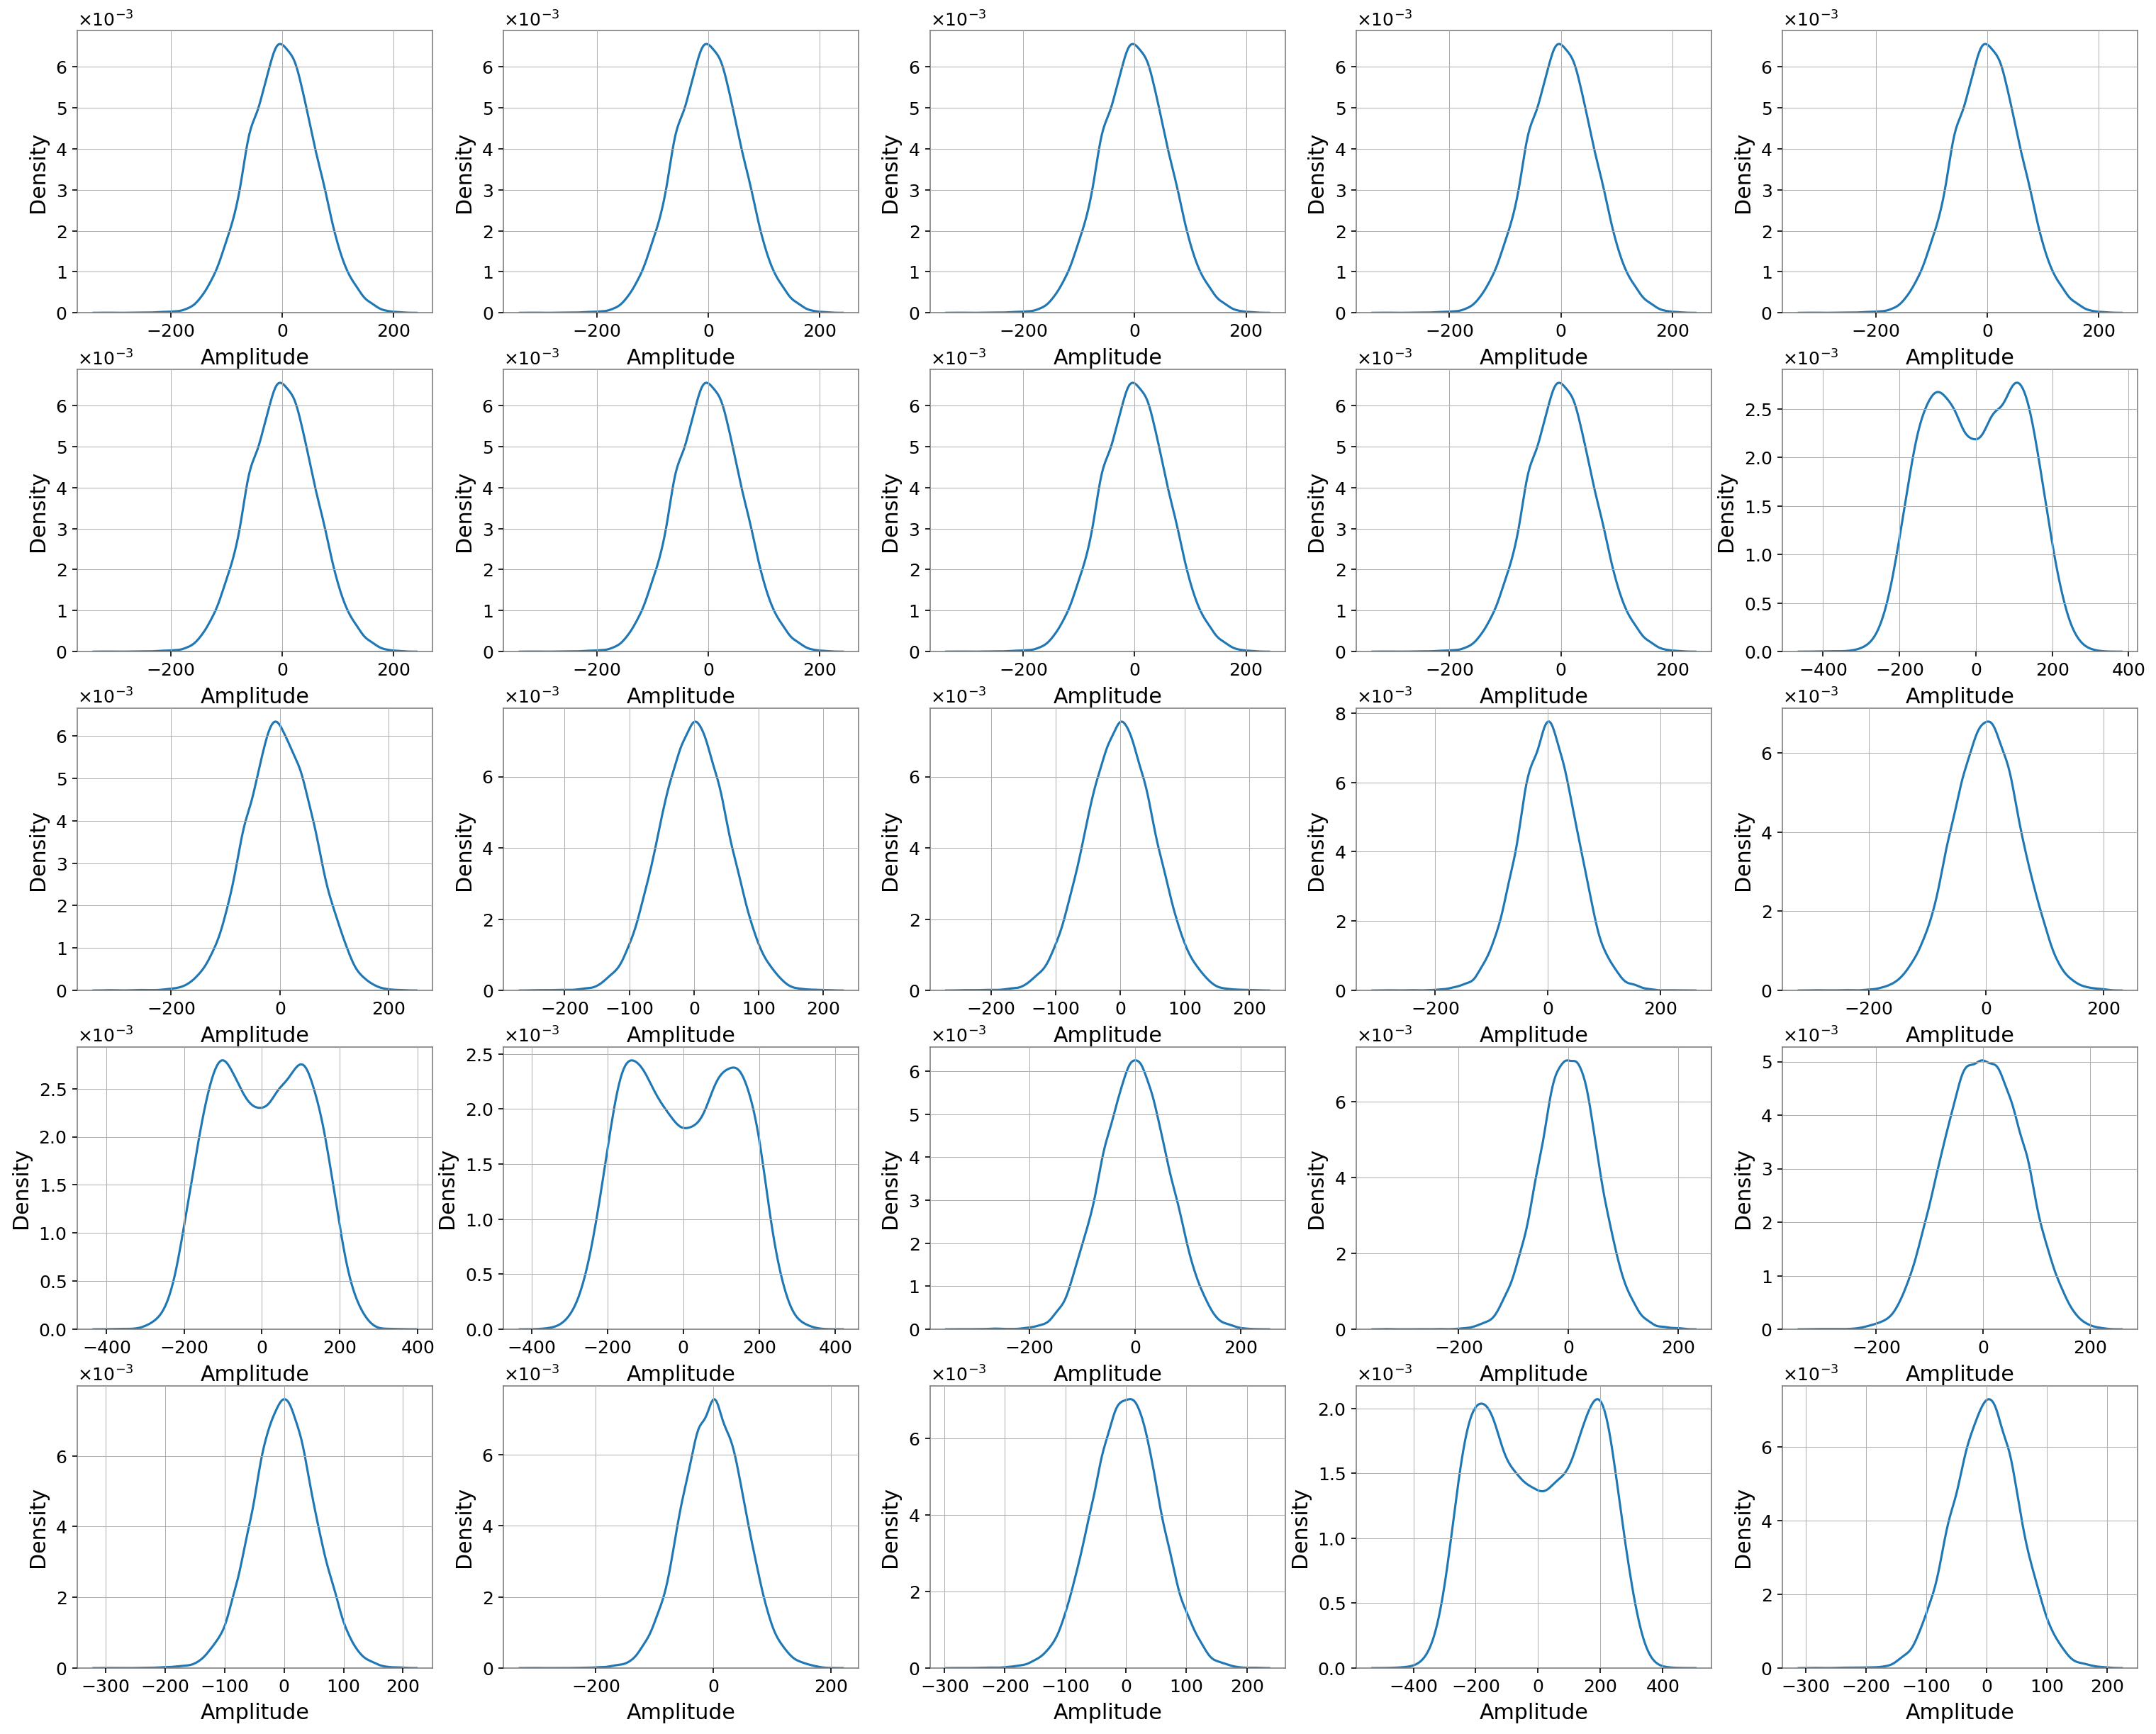

In [8]:
fig, axes = plt.subplots(5,5, figsize=(25,20), dpi=150)

# Looping through the axes
for idx, ax in enumerate(list(itertools.chain.from_iterable(axes))):
    sns.kdeplot(ax=ax, data=data_df['data'].iloc[idx].value)
    ax.set_xlabel('Amplitude')

plt.show()


/home/ashishmathew0297/miniconda3/envs/gengli_env/lib/python3.12/site-packages/gwpy/plot/axes.py:567: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  return super().legend(*args, **kwargs)


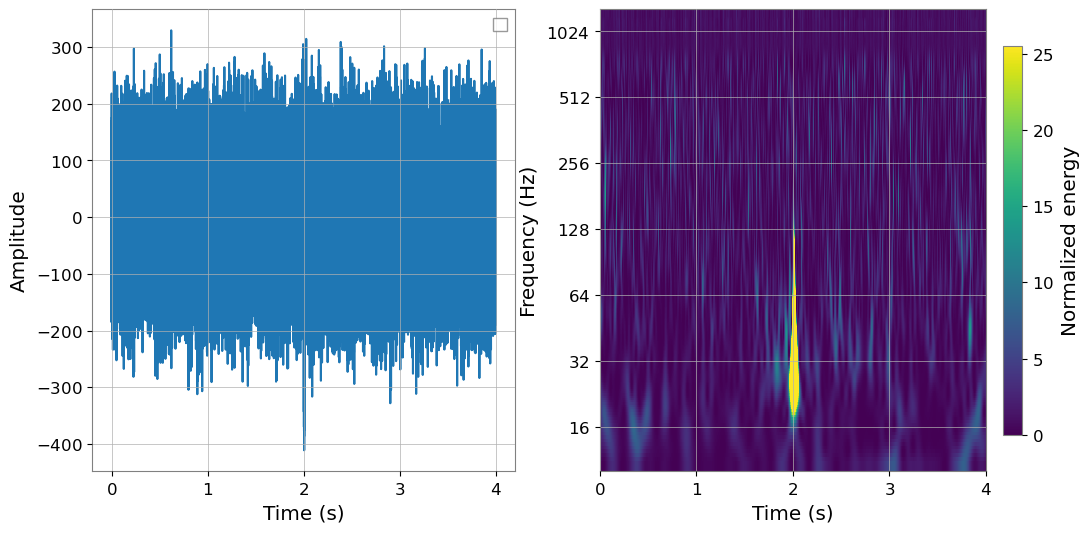

In [9]:
glitch_idx = 9

fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].plot(data_df['data'].iloc[glitch_idx].times, data_df['data'].iloc[glitch_idx].value)
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Amplitude")
ax[0].legend()

ax[1].imshow(data_df['q_transform'].iloc[glitch_idx])
ax[1].set_yscale('log', base=2)
ax[1].set_xscale('linear')
ax[1].set_ylabel('Frequency (Hz)')
ax[1].set_xlabel('Time (s)')
ax[1].images[0].set_clim(0, 25.5)
fig.colorbar(ax[1].images[0], ax=ax[1], label='Normalized energy', orientation='vertical', fraction=0.046, pad=0.04)

plt.show()

# The Shapiro Wilk Test

The null hypothesis of this test is that our data comes from a normal distribution. This test only works for univariate, continuous data.

Given a sample $x_{1} \dots x_{n}$, with $n$ as the number of data points the Shapiro-Wilks test statistic is given by $W$ as follows

$$
W = \frac{(\sum_{i=1}^{n}a_{i}x_{(i)})^2}{\sum_{i=1}^{n}(x_i - \bar{x})^2}
$$

If a distribution is normal then, $(\sum_{i=1}^{n}a_{i}x_{(i)})^2$ should be an estimate of the population's variance $\sigma^2$

The denominator here is also an estimation of population variance $\sigma^2$

So, for the null hypothesis here to hold absolutely true: $W=1$; since the numerator and denominator are both estimating the variance.

In our case with the glitched infused data, if the W statistic here lies close 

For values less than one, it indicates a non-normal distribution

### Issues with this test

- It won't work well if our data has too many equal values
- For a small dataset, our null hypothesis will rarely get rejected
- For a large dataset, our null hypothesis will be rejected for tiny differences from normality

A large p value doesn't prove that a distribution is normal, but that it is not significantly difference from a normal distribution.

### Note

Shapiro Wilks test is too sensitive - a histogram/Q-Q plot should be used when assessing it if we face issues due to this.

### About "a"

Taking the numerator

$$(\sum_{i=1}^{n}a_{i}x_{(i)})^2$$

Here, $x_{(i)}$ are the ["order statistics"](https://youtu.be/gDtkGqLD1R0), that is, the values obtained from the sample when sorted in ascending order.

$a_i$ are constants given by

$$
\frac{m^TV^{-1}}{||V^{-1}m||}
$$

Here, $m$ represents a vector of order statistics we would expect from a standard normal distribution.

$V$ is the covariance matrix given by

$$
V = \mu[X_i - \mu X_i][X_j - \mu X_j]
$$

where $\mu$ is the expected mean of the distribution.

So, for example, if we had two points, $a$ would be $[0.5]$, for 3 points, $[0.375, 0.625]$, for 4 points, $[0.2857, 0.5, 0.7143]$,  and so on.

### The issue with order statistics here

The data we are using has a temporal component to it. The Shapiro Wilk test requires rearrangement of the data points, hence rendering this temporal component useless to us. We can still investigate this but will only be able to treat the wave data objectively, like how we would a normal distribution.

### Q-Q plots

These plot quantiles of our data vs expected quantiles of a normal distribution.

This is a good alternative to checking the Shapiro p-value

(Quantile = fraction of points below a given value)
![q-q plot](ad_4nxcrzsncc66mesuuafrmu-n91-w2j72w29cr-sb_o5_9y4k4errnbl3ei0req8twyso1snfa3haoctju5kfnadqygfo0micewassf3ljzvx1thwjgoytvchzbxyqmqdsemaovm7beg.avif)

I will now apply the Shapiro Wilks test to the data and study it a bit to see how it fares.

In [10]:
data_df['shapiro_pvalue'] = data_df['data'].apply(lambda y: stats.shapiro(y.value).pvalue)
data_df['shapiro_statistic'] = data_df['data'].apply(lambda y: stats.shapiro(y.value).statistic)
# display_shapiro_stats(data_df_4096, 3)

/home/ashishmathew0297/miniconda3/envs/gengli_env/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 16384.
  res = hypotest_fun_out(*samples, **kwds)
/home/ashishmathew0297/miniconda3/envs/gengli_env/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 16384.
  res = hypotest_fun_out(*samples, **kwds)


Given the warning above, and also the written content, it is clear that there is a chance of the Shapiro-Wilks test failing for our data since we sample the noise and glitch at 4096 Hz by default, giving us 8192 points on either side of our glitch in the case of a time window of 3 seconds (reduced to 2 by our code to load up the dataset).

Taking a time window below 1 second on either side might be doable but has a chance of cutting off parts of the glitch since the average glitch timeframe is around 0.66 seconds.

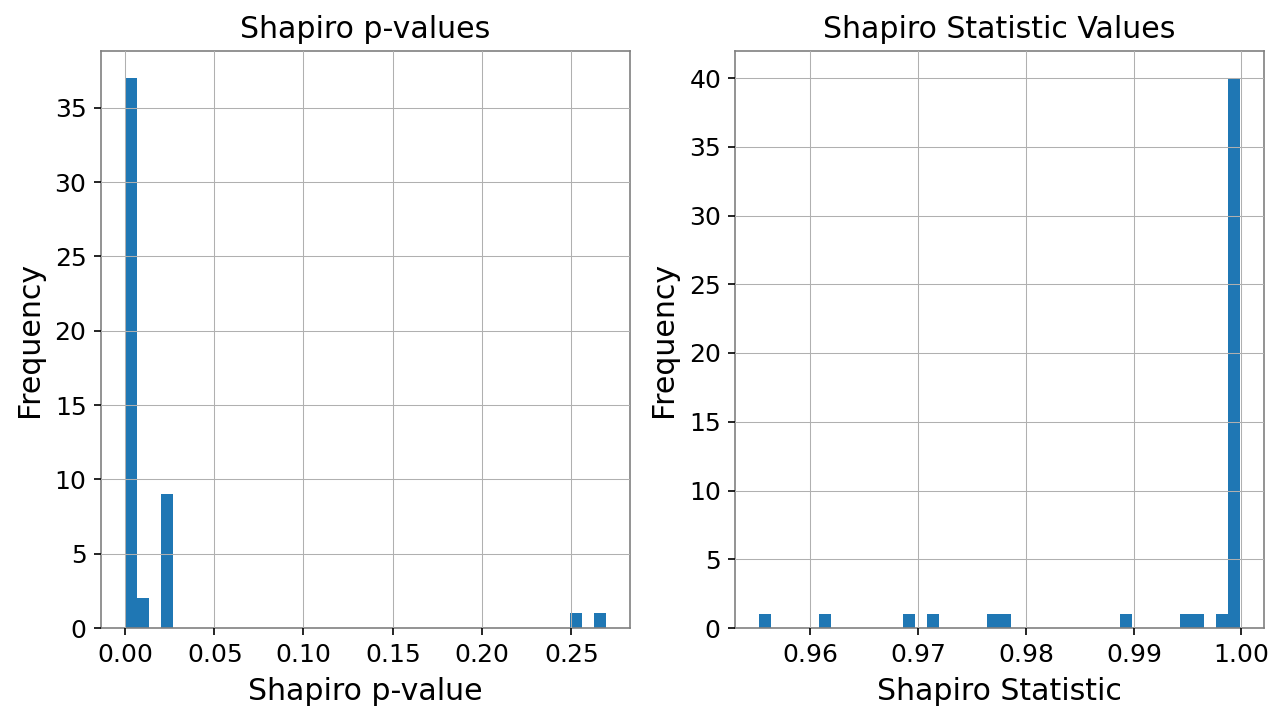

Number of Shapiro p-values above 0.05: 2
Max Shapiro p-value: 0.2694255554950772
Min Shapiro p-value: 1.778669706104033e-56


In [11]:
fig, ax = plt.subplots(1,2, figsize=(10,5), dpi=150)
ax[0].hist(data_df['shapiro_pvalue'], bins=40)
ax[0].set_xlabel('Shapiro p-value')
ax[0].set_ylabel('Frequency')
# ax[0].set_xticks(list(np.arange(data_df['shapiro_pvalue'].min(), data_df['shapiro_pvalue'].max()+0.01, 0.01)), fontsize=8, rotation=90)
ax[0].set_title('Shapiro p-values')
ax[1].hist(data_df['shapiro_statistic'], bins=40)
ax[1].set_xlabel('Shapiro Statistic')
ax[1].set_ylabel('Frequency')
# ax[1].set_xticks(list(np.arange(data_df['shapiro_statistic'].min(), data_df['shapiro_pvalue'].max()+0.01, 0.01)), fontsize=8, rotation=90)
ax[1].set_title('Shapiro Statistic Values')
plt.show()
print(f"Number of Shapiro p-values above 0.05: {(data_df['shapiro_pvalue'] > 0.05).sum()}")
print(f"Max Shapiro p-value: {data_df['shapiro_pvalue'].max()}")
print(f"Min Shapiro p-value: {data_df['shapiro_pvalue'].min()}")

# The Kolmogorov-Smirnov Test

[Reference 1](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test)

[Reference 2](https://youtu.be/cWvksMG2yr8)

This is a t-test, a statistical method to determine whether there is a significant difference between the means of two groups based on a sample of data

This test is used to check the equality of probability distributions. It has two forms, the 1-sample and 2-sample test.

The 1-sample test checks whether our data comes from a reference distribution (a normal distribution in our case)

The 2-sample test compares 2 samples to see if they come from the same distribution.

### 1-Sample KS statistic

The empirical distribution function for 'n' independent and identically distributed "ordered observations" $X_i$ is given by

$$F_n(x) = \frac{n_{\le x}}{n}$$

or

$$F_n(x) = \frac{1}{n}\sum\limits_{i=1}^{n}1_{(-\infty,x]}(X_i)$$

Here the indicator function $1_{(-\infty,x]}(X_i)$ is zero for all values of $X_i$ above x.

Using the above, the KS statistic for a given CDF $F(x)$ is

$$D_n = \sup_x|F_n(x) - F(x)|$$

where $\sup_x$ is the supremum of the distances

What is basicaly happening here is that for each value of $x$ the KS statistic compares our current distribution and the empirical distribution, and takes the largest absolute difference between them.

If the sample $F_n(x)$ comes from the distribution $F(x)$ or is very close to it, then $D_n$ will have a value close to 1.

This statistic requires a large number of data points to properly reject the null hypothesis (that both samples are of the same distribution)

## What does this mean for our use case?

In our case, the closer our glitch is to a gaussian, the lower the value of the KS-statistic will be, since the KS statistic is reminiscent of a "Distance" value of our sample distribution from a normal distribution.

The p-value gives us 0.0 for all the cases which would tell us that the two samples come from different distributions. However, this was done comparing it with a random distribution instead of white noise generated by gwpy taking the PSD into consideration.

In [12]:
np.random.seed(42)

# ks_statistic = list(data_df['data'].apply(lambda y: stats.kstest(y.value, 'norm')))
data_df[['ks_statistic', 'ks_p_value']] = list(data_df['data'].apply(lambda y: stats.kstest(y.value, 'norm')))

In [13]:
data_df.head()

,GPStime,glitch,data,q_transform,shapiro_pvalue,shapiro_statistic,ks_statistic,ks_p_value
0,1.246712e+09,[TimeSeries(1.55428264e-19\n unit: d...,[TimeSeries(8.31519287\n unit: dimen...,[[FrequencySeries(0.17051595\n ...,0.020294,0.999719,0.478891,0.0
1,1.246712e+09,[TimeSeries(1.55428264e-19\n unit: d...,[TimeSeries(8.31519287\n unit: dimen...,[[FrequencySeries(0.17051595\n ...,0.020294,0.999719,0.478891,0.0
2,1.246712e+09,[TimeSeries(1.55428264e-19\n unit: d...,[TimeSeries(8.31519287\n unit: dimen...,[[FrequencySeries(0.17051595\n ...,0.020294,0.999719,0.478891,0.0
3,1.246712e+09,[TimeSeries(1.55428264e-19\n unit: d...,[TimeSeries(8.31519287\n unit: dimen...,[[FrequencySeries(0.17051595\n ...,0.020294,0.999719,0.478891,0.0
4,1.246712e+09,[TimeSeries(1.55428264e-19\n unit: d...,[TimeSeries(8.31519287\n unit: dimen...,[[FrequencySeries(0.17051595\n ...,0.020294,0.999719,0.478891,0.0


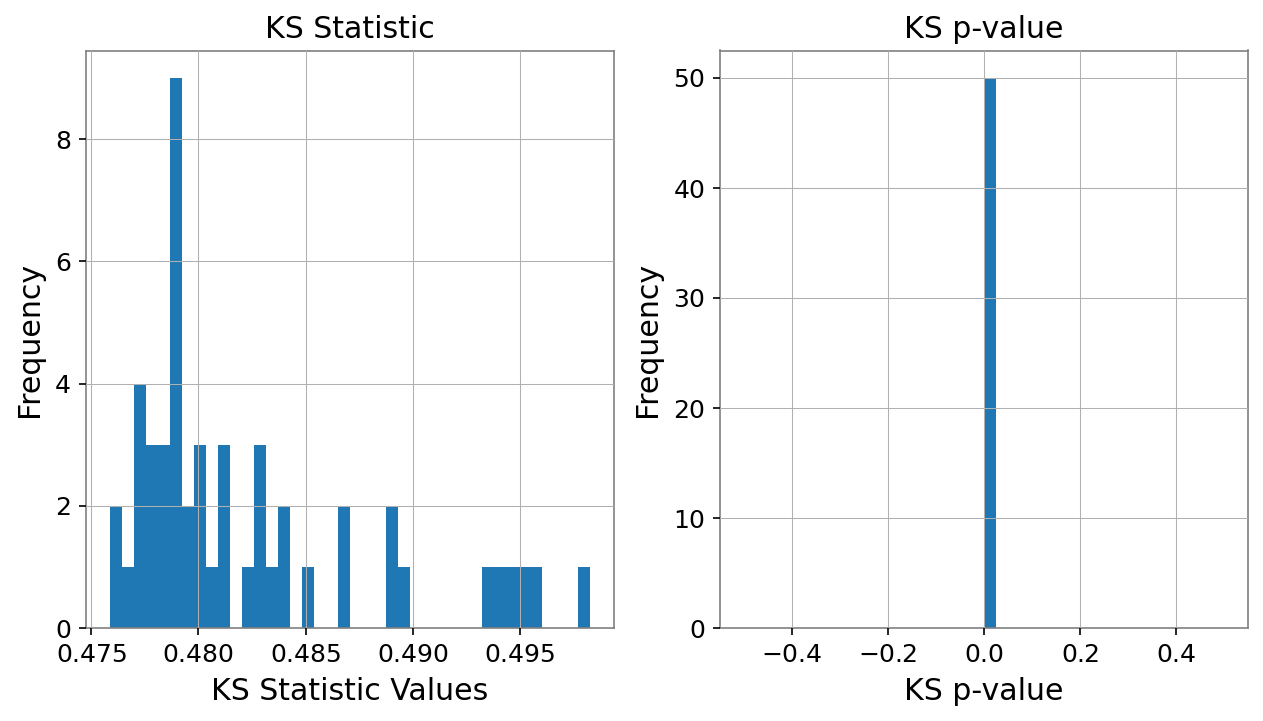

Max KS p-value: 0.0
Min KS p-value: 0.0
Max KS Statistic value: 0.4982589333983382
Min KS Statistic value: 0.4758573741068153


In [14]:
fig, ax = plt.subplots(1,2, figsize=(10,5), dpi=150)
ax[0].hist(data_df['ks_statistic'], bins=40)
ax[0].set_xlabel('KS Statistic Values')
ax[0].set_ylabel('Frequency')
# ax[0].set_xticks(list(np.arange(data_df['shapiro_pvalue'].min(), data_df['shapiro_pvalue'].max()+0.01, 0.01)), fontsize=8, rotation=90)
ax[0].set_title('KS Statistic')
ax[1].hist(data_df['ks_p_value'], bins=40)
ax[1].set_xlabel('KS p-value')
ax[1].set_ylabel('Frequency')
# ax[1].set_xticks(list(np.arange(data_df['shapiro_statistic'].min(), data_df['shapiro_pvalue'].max()+0.01, 0.01)), fontsize=8, rotation=90)
ax[1].set_title('KS p-value')
plt.show()
# print(f"Number of KS p-values above 0.05: {(data_df['shapiro_pvalue'] > 0.05).sum()}")
print(f"Max KS p-value: {data_df['ks_p_value'].max()}")
print(f"Min KS p-value: {data_df['ks_p_value'].min()}")
print(f"Max KS Statistic value: {data_df['ks_statistic'].max()}")
print(f"Min KS Statistic value: {data_df['ks_statistic'].min()}")

# The Anderson-Darling Test

[Source](https://en.wikipedia.org/wiki/Anderson%E2%80%93Darling_test)

This is yet another test for normality that can easily be done using the SciPy package in Python.

This test is not as good as the Shapiro-Wilk test but is better than a lot of other tests.

The response we receive will contain our **statistic** along with a **significance level** and **critical values**. 


In [15]:
data_df['AD_test'] = data_df['data'].apply(lambda y: stats.anderson(y.value, dist='norm'))

In [16]:
data_df['AD_test'].iloc[45]

AndersonResult(statistic=np.float64(19.91560955191744), critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(0.03979074575371386), scale=np.float64(89.0339253195407))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

# Shifting away from the usual normality tests

Treating our dataset as a distribution might not consistently give us definite proof of distinguishing between a glitch and a gaussian. We might need to look into methods that can be coupled with these tests that help study the signal better.

Additionally, treating an interferometer signal as a distribution without taking into consideration the temporal aspects of it does not capture the actual shape of the signal that leads to the particular glitch occurring. All of these tests shuffle the points of our waveform around, hence hiding the trends that could follow a glitch's occurrence.

Some ideas I have to test the gaussianity of our data are as follows 

- **z-score** and **modified z-score**
- **Ljung-Box test:** It's an enhanced version of the $\chi^2$ test
- **Isolation Forest (or CARTs):** [Source 1](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html), [Source 2](https://neptune.ai/blog/anomaly-detection-in-time-series) This algorithm is a derivative of the Random Forest algorithm that, based on a contamination metric, can help find outliers in our data. However it might not work in our case
- **Moving Averages**
- **Autoregressive approaches/ARIMA (Autoregressive Integrated Moving Average)** 
- **Clustering like K-means or DBSCAN (Density-based spatial clustering of applications with noise)**
- **Hierarchial Clustering**
- **z-score** [Source](https://app.myeducator.com/reader/web/1421a/3/d653e/)
- **Local Outlier Factor**
- Some of the methods in [this](https://s-ai-f.github.io/Time-Series/outlier-detection-in-time-series.html#statistical-based-approaches) link.

These methods, though deceptively simple, are capable of giving us a good idea of what we could do to help detect a glitch or any other type of non-gaussianity in our dataset. However, there also lies a problem in their simplicity, in that these methods may not be able to capture all the intricate details that would point us towards the presence of a glitch and in some cases, they may need a good level of fine-tuning to get to work decently.

Another method is to use Autoencoders, which has already been explored in the past. A drawback here is that deep learning is a black box, so we will not know the exact method our algorithm is using to determine the presence of a glitch in our data. However, this is something that we can explore later, our main focus is to study the gaussianity of our data with these methods.

# Some approaches I have been thinking of

Now, directly using tests for normality is a decent approach, however they can be deceptive since they aren't nuanced enough to capture paterns in our time series that could point to a glitch. My approach is a bit of the opposite.

### Anomaly Detection

My approach is along the lines of training a small anomaly detection model using either actual or syntheic glitches injected into gaussian noise, and then studying it to see if it holds in determining the gaussian nature of it. This would be paired with a few normality tests to confirm a certain level of non gaussian characteristics.

The idea here is that with a large enough sample size, we can help capture any inconsistencies in our data

### The DSP approach

This approach references a text I read related to digital signal processing (The Digital Signal Processing Handbook by Vijay Madisetti, Section V, Chapter 16, 16.2.1 and 16.3.2 (along with the previous parts)) which discusses validation, testing and noise modelling.

### Questions

- A lot of anomaly detection methods are designed around higher dimension data (Isolation forests for example), would it still be a good idea to try and see what could come of it if more dimensions could be taken into consideration (SNR, amplitude, Q-value, duration, etc)
- I experimented with exponentially weighted averages before and it seems like it helped separate out the glitch from the white noise to a certain extent. However, in weighted averages the average value at a certain point will be affected.

# Z-score test

The z-score tells us how far a point in our distribution lies from the mean in terms of the standard deviations. This can be useful in the case of time-series as it doesn't involve moving the points from their original positions when calculating the statistic.

For a given point $x$, taking the mean $\mu$ and standard deviation $\sigma$ of the distribution, we can calculate the z-score for each of the points as follows,

$$Z = \frac{x-\mu}{\sigma}$$

using it to determine whether a point is an outlier or not. A high $Z$ value (usually $|Z| \geq 3$ but a higher threshold could be used) would indicate an outlier.

For our data we could use either the whole dataset to compute our value, or use rolling z-scores to study local anomalies.

Since a lot of our data is skewed here, we might have to use modified z-score which uses the median and mean absolute deviation (MAD) instead of the normal mean and standard deviation.

MAD is more robust to normal standard deviation as it is less affected by extreme values. It is given as follows

$$\text{MAD} = \text{median}(|x_i - \text{median}|(x))$$

Hence, the modified Z-score would be

$$Z = \frac{0.6745(x - \text{median})}{\text{MAD}}$$

In this case we consider outliers to have the absolute z-values above 3.5.

Let's apply this test to see how it performs with our data.

In [17]:
def modified_zscore(data):
    median = np.median(data)
    mad = np.median(np.abs(data - median))
    modified_z = 0.6745 * (data - median) / mad if mad != 0 else np.zeros(len(data))
    return modified_z

In [18]:
data_df["zscores"] = data_df['data'].apply(lambda y: stats.zscore(y.value))
data_df["modified_zscores"] = data_df['data'].apply(lambda y: modified_zscore(y.value))

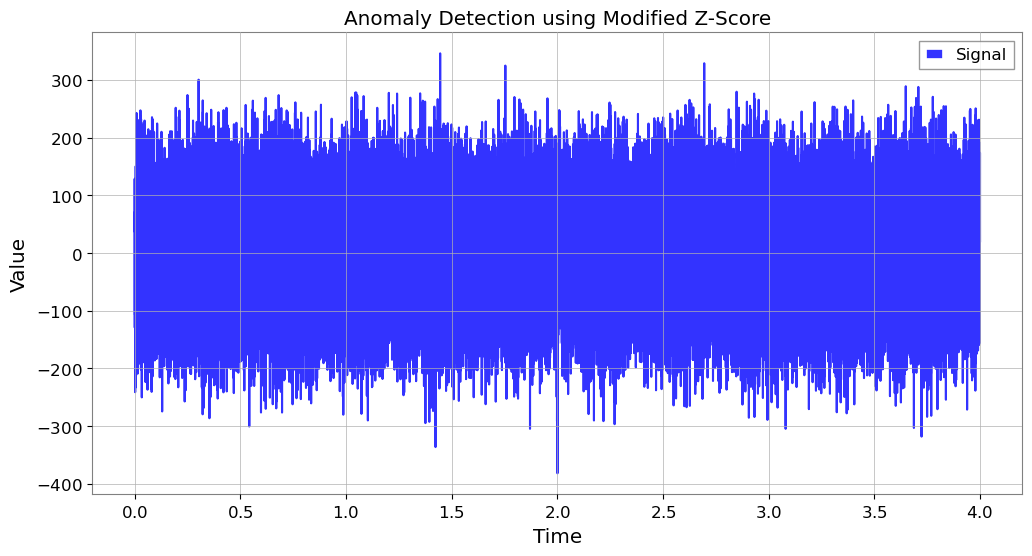

In [65]:
idx = 15
outlier_indexes = np.where(np.abs(data_df["modified_zscores"][idx]) > 3.5)
mod_zscore_outlier_times = data_df['data'].iloc[idx].times[outlier_indexes]
mod_zscore_outlier_values = data_df['data'].iloc[idx].value[outlier_indexes]

plt.figure(figsize=(12, 6))
sns.lineplot(x=data_df['data'].iloc[idx].times, y=data_df['data'].iloc[idx].value, label='Signal', color='blue', linewidth=1.5, alpha=0.8)
sns.scatterplot(x=mod_zscore_outlier_times, y=mod_zscore_outlier_values, color='red', label='Modified Z-Score Anomalies', marker='X', s=80)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Anomaly Detection using Modified Z-Score")
plt.show()

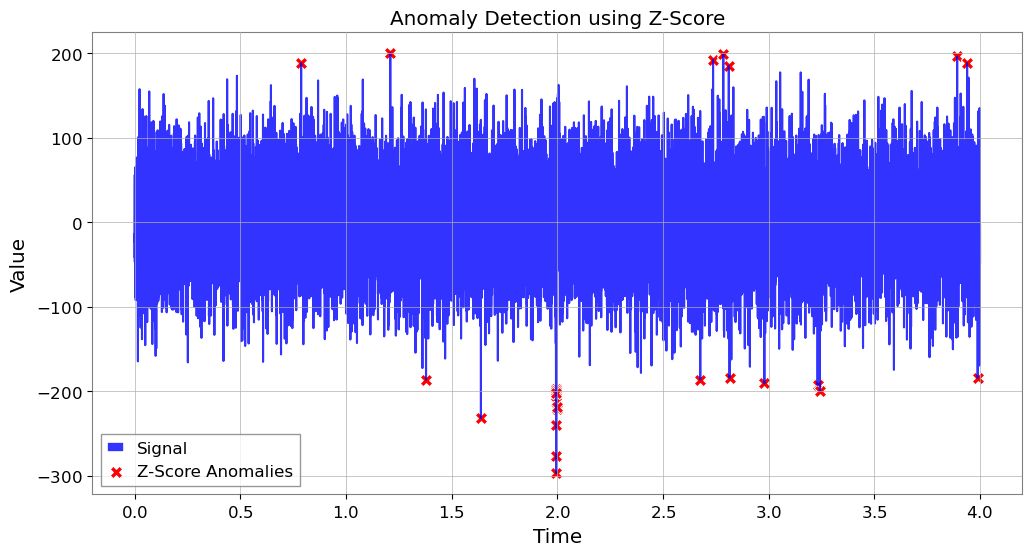

In [69]:
idx = 20
outlier_indexes = np.where(np.abs(data_df["modified_zscores"][idx]) > 3.5)
zscore_outlier_times = data_df['data'].iloc[idx].times[outlier_indexes]
zscore_outlier_values = data_df['data'].iloc[idx].value[outlier_indexes]

plt.figure(figsize=(12, 6))
sns.lineplot(x=data_df['data'].iloc[idx].times, y=data_df['data'].iloc[idx].value, label='Signal', color='blue', linewidth=1.5, alpha=0.8)
sns.scatterplot(x=zscore_outlier_times, y=zscore_outlier_values, color='red', label='Z-Score Anomalies', marker='X', s=80)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Anomaly Detection using Z-Score")
plt.show()

We can see that this test works well for some cases but fails to detect anomalies for other cases (example index 15). Hence this test might not be as reliable given our dataset's nature.

It does however work well in the cases that it does capture any anomalies. Here, using a few density based clustering algorithms, we could identify which of the points would form a possible glitch in our data.